In [1]:
#import libraries
import os
from pandas import read_csv
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

%matplotlib inline

import pandas_profiling


from scipy.stats import skew, norm
from scipy import stats
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn import linear_model
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, classification_report, accuracy_score
from math import sqrt



from lightgbm import LGBMRegressor
import lightgbm as lgb

In [2]:
#import data
current_path = os.getcwd()
current_path = os.path.dirname(current_path)
print(current_path)
#C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone\data_mart
dataset = current_path + '//data_mart//reporting_rb.csv'
print(dataset)
dataset = pd.read_csv(dataset, index_col = 0)
dataset.head()

#https://stackoverflow.com/questions/9856683/using-pythons-os-path-how-do-i-go-up-one-directory

C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone
C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone//data_mart//reporting_rb.csv


,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,rushing_rush_att_pg_zscore,rushing_rush_td_pg_zscore,rushing_rush_yds_pg_zscore,rushing_scrim_plays_pg_zscore,rushing_scrim_tds_pg_zscore,rushing_scrim_yds_pg_zscore,football_spending_zscore,coaches_salaries_zscore,ticket_sales_zscore,max_madden
fms_id,,,,,,,,,,,,,,,,,,,,,
113,3886636.0,Alex Barnes,Alex,Barnes,RB,RB,O,Kansas State,2019,NaN,...,-0.010877,0.089511,0.164368,-0.132464,-0.119293,-0.051690,-0.665105,-0.147962,-0.371611,63.0
136,4048244.0,Alexander Mattison,Alexander,Mattison,RB,RB,O,Boise State,2019,NaN,...,0.462081,0.561893,0.152931,0.492119,0.404870,0.186999,-0.752597,-0.758796,-0.983711,68.0
414,NaN,Benny Snell,Benny,Snell,RB,RB,O,Kentucky,2019,NaN,...,1.236402,1.672389,1.115162,1.056488,1.380955,0.783732,-0.502771,-0.134797,0.678511,69.0
645,3931398.0,Bryce Love,Bryce,Love,RB,RB,O,Stanford,2019,NaN,...,-0.327105,-0.223216,0.324403,-0.374233,-0.297134,0.203636,NaN,NaN,NaN,71.0
1182,3925347.0,Damien Harris,Damien,Harris,RB,RB,O,Alabama,2019,NaN,...,-0.923499,-0.794232,-0.528113,-0.947424,-0.849318,-0.640466,2.052018,2.142288,0.910284,69.0


In [3]:
#determine which columns have None values
none_columns = []
for x in dataset.columns:
    if dataset[x].isnull().values.any() == True:
        none_columns.append(x)
print(none_columns)

['espn_id', 'selection_number', 'position_rank', 'position_group_rank', 'section_rank', 'drafting_team', 'home_city', 'home_state', 'home_country', 'forty', 'vertical', 'bench', 'broad', 'threecone', 'shuttle', 'forty_zscore', 'vertical_zscore', 'bench_zscore', 'broad_zscore', 'threecone_zscore', 'shuttle_zscore', 'max_madden_zscore', 'rushing_rec_td_pg_zscore', 'rushing_rec_yards_pg_zscore', 'rushing_receptions_pg_zscore', 'rushing_rush_att_pg_zscore', 'rushing_rush_td_pg_zscore', 'rushing_rush_yds_pg_zscore', 'rushing_scrim_plays_pg_zscore', 'rushing_scrim_tds_pg_zscore', 'rushing_scrim_yds_pg_zscore', 'football_spending_zscore', 'coaches_salaries_zscore', 'ticket_sales_zscore', 'max_madden']


In [4]:
def z_score_rescale(data_mean, data_std, z_score):
    X = (z_score* data_std) + data_mean
    return X

In [5]:
dataset['max_madden'].describe()

count    320.000000
mean      75.746875
std        9.358834
min       57.000000
25%       68.000000
50%       74.000000
75%       82.250000
max       99.000000
Name: max_madden, dtype: float64

In [6]:
#Deal with None Values
none_dict = {'espn_id': 0,    
    'selection_number': 400,
    'position_rank': 400,
    'position_group_rank': 400,
    'section_rank': 400,
    'drafting_team': 'No Team',
    'home_city': 'No City',
    'home_state': 'No State',
    'home_country': 'USA',
    'forty': 0,
    'vertical': 0, 
    'bench': 0, 
    'broad': 0,
    'threecone': 0,
    'shuttle': 0,
    'max_madden': dataset['max_madden'].min() - 10,
    'forty_zscore': dataset['forty_zscore'].mean(), 
    'vertical_zscore': dataset['vertical_zscore'].mean(), 
    'bench_zscore': dataset['bench_zscore'].mean(), 
    'broad_zscore': dataset['broad_zscore'].mean(), 
    'threecone_zscore': dataset['threecone_zscore'].mean(), 
    'shuttle_zscore': dataset['shuttle_zscore'].mean(), 
    'max_madden_zscore': dataset['max_madden_zscore'].min() - 0.1,
    'rushing_rec_td_pg_zscore': dataset['rushing_rec_td_pg_zscore'].min(), 
    'rushing_rec_yards_pg_zscore': dataset['rushing_rec_yards_pg_zscore'].min(), 
    'rushing_receptions_pg_zscore': dataset['rushing_receptions_pg_zscore'].min(), 
    'rushing_rush_att_pg_zscore': dataset['rushing_rush_att_pg_zscore'].min(), 
    'rushing_rush_td_pg_zscore': dataset['rushing_rush_td_pg_zscore'].min(), 
    'rushing_rush_yds_pg_zscore': dataset['rushing_rush_yds_pg_zscore'].min(), 
    'rushing_scrim_plays_pg_zscore': dataset['rushing_scrim_plays_pg_zscore'].min(), 
    'rushing_scrim_tds_pg_zscore': dataset['rushing_scrim_tds_pg_zscore'].min(), 
    'rushing_scrim_yds_pg_zscore': dataset['rushing_scrim_yds_pg_zscore'].min(),
    'football_spending_zscore': dataset['football_spending_zscore'].min(), 
    'coaches_salaries_zscore':  dataset['coaches_salaries_zscore'].min(), 
    'ticket_sales_zscore':  dataset['ticket_sales_zscore'].min()}

print(none_dict)

for none_col in none_columns:
    dataset[none_col] = dataset[none_col].fillna(none_dict[none_col])
   

#https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

{'espn_id': 0, 'selection_number': 400, 'position_rank': 400, 'position_group_rank': 400, 'section_rank': 400, 'drafting_team': 'No Team', 'home_city': 'No City', 'home_state': 'No State', 'home_country': 'USA', 'forty': 0, 'vertical': 0, 'bench': 0, 'broad': 0, 'threecone': 0, 'shuttle': 0, 'max_madden': 47.0, 'forty_zscore': 3.4006520038323862e-15, 'vertical_zscore': 9.585701825668018e-16, 'bench_zscore': 2.562902902617277e-16, 'broad_zscore': 9.620174807203257e-16, 'threecone_zscore': -3.794675906094223e-15, 'shuttle_zscore': 2.4308040960213954e-15, 'max_madden_zscore': -2.106258132775872, 'rushing_rec_td_pg_zscore': -0.9661947130048169, 'rushing_rec_yards_pg_zscore': -1.5350613749540352, 'rushing_receptions_pg_zscore': -1.6038212148585833, 'rushing_rush_att_pg_zscore': -2.7997482644439318, 'rushing_rush_td_pg_zscore': -2.0995762414461763, 'rushing_rush_yds_pg_zscore': -2.7215545470749296, 'rushing_scrim_plays_pg_zscore': -2.9229731405194936, 'rushing_scrim_tds_pg_zscore': -2.194102

In [7]:
dataset.head()

,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,rushing_rush_att_pg_zscore,rushing_rush_td_pg_zscore,rushing_rush_yds_pg_zscore,rushing_scrim_plays_pg_zscore,rushing_scrim_tds_pg_zscore,rushing_scrim_yds_pg_zscore,football_spending_zscore,coaches_salaries_zscore,ticket_sales_zscore,max_madden
fms_id,,,,,,,,,,,,,,,,,,,,,
113,3886636.0,Alex Barnes,Alex,Barnes,RB,RB,O,Kansas State,2019,400.0,...,-0.010877,0.089511,0.164368,-0.132464,-0.119293,-0.051690,-0.665105,-0.147962,-0.371611,63.0
136,4048244.0,Alexander Mattison,Alexander,Mattison,RB,RB,O,Boise State,2019,400.0,...,0.462081,0.561893,0.152931,0.492119,0.404870,0.186999,-0.752597,-0.758796,-0.983711,68.0
414,0.0,Benny Snell,Benny,Snell,RB,RB,O,Kentucky,2019,400.0,...,1.236402,1.672389,1.115162,1.056488,1.380955,0.783732,-0.502771,-0.134797,0.678511,69.0
645,3931398.0,Bryce Love,Bryce,Love,RB,RB,O,Stanford,2019,400.0,...,-0.327105,-0.223216,0.324403,-0.374233,-0.297134,0.203636,-2.147348,-2.162277,-1.476890,71.0
1182,3925347.0,Damien Harris,Damien,Harris,RB,RB,O,Alabama,2019,400.0,...,-0.923499,-0.794232,-0.528113,-0.947424,-0.849318,-0.640466,2.052018,2.142288,0.910284,69.0


In [8]:
#create categories for Madden Scores
def f(row):
    if row['max_madden'] >= 90 : val = 90
    elif row['max_madden'] < 90 and row['max_madden'] >= 80 : val = 80
    elif row['max_madden'] < 80 and row['max_madden'] >= 70 : val = 70  
    elif row['max_madden'] < 70 and row['max_madden'] >= 60 : val = 60
    elif row['max_madden'] < 60 and row['max_madden'] >= 50 : val = 50
    elif row['max_madden'] < 50 and row['max_madden'] >= 40 : val = 40
    else: val = 40
    return val
dataset['madden_cat'] = dataset.apply(f, axis=1)



In [9]:

#determine % of no madden scores wanted
no_madden_percentage = .20

no_madden_df = dataset.loc[dataset['madden_cat'] == 40]
madden_df = dataset.loc[dataset['madden_cat'] != 40]

print(no_madden_df.shape)
print(madden_df.shape)

current_no_madden_percentage = no_madden_df.shape[0] / dataset.shape[0] - no_madden_percentage
print(current_no_madden_percentage)
if current_no_madden_percentage > 0:
    remove_num = int(current_no_madden_percentage * dataset.shape[0])
    random_no_madden = np.random.choice(no_madden_df.index, remove_num)
    no_madden_df = no_madden_df.drop(random_no_madden)

print(no_madden_df.shape[0] / (no_madden_df.shape[0] + madden_df.shape[0]))
dataset = madden_df.append(no_madden_df)
dataset.head()
dataset = shuffle(dataset)
dataset.head()

#https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset

(207, 72)
(320, 72)
0.1927893738140417
0.2841163310961969


,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,rushing_rush_td_pg_zscore,rushing_rush_yds_pg_zscore,rushing_scrim_plays_pg_zscore,rushing_scrim_tds_pg_zscore,rushing_scrim_yds_pg_zscore,football_spending_zscore,coaches_salaries_zscore,ticket_sales_zscore,max_madden,madden_cat
fms_id,,,,,,,,,,,,,,,,,,,,,
522,0.0,Brandon Jacobs,Brandon,Jacobs,RB,RB,O,Southern Illinois,2005,300.0,...,-1.392333,-1.400696,-1.798456,-1.523780,-1.607332,-2.147348,-2.162277,-1.476890,90.0,90
2885,0.0,Keith Brown,Keith,Brown,RB,RB,O,UCLA,2000,300.0,...,-2.099576,-2.721555,-2.922973,-2.194103,-2.900718,0.156419,-0.378782,0.024653,47.0,40
3184,0.0,LeGarrette Blount,LeGarrette,Blount,RB,RB,O,Oregon,2010,300.0,...,1.539781,-0.106294,-0.867794,1.255269,-0.489144,-0.110380,0.142648,0.099217,87.0,80
3676,0.0,Montario Hardesty,Montario,Hardesty,RB,RB,O,Tennessee,2010,59.0,...,-0.473397,-0.839922,-0.457316,-0.593535,-0.898418,1.006362,0.506257,0.987988,72.0,70
2434,0.0,Jerome Harrison,Jerome,Harrison,RB,RB,O,Washington State,2006,145.0,...,1.383062,2.197563,1.832736,1.238765,2.013236,-0.868396,-0.751348,-1.016057,83.0,80


In [10]:

#Total Features
"""['espn_id', 'full_name', 'first_name', 'last_name', 'position',
       'position_group', 'section', 'college', 'draft_year',
       'selection_number', 'position_rank', 'position_group_rank',
       'section_rank', 'drafting_team', 'home_city', 'home_state',
       'home_country', 'college_weight_pounds', 'college_height_inches',
       'hw_ratio', 'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'rushing_games', 'rushing_rec_td', 'rushing_rec_yards',
       'rushing_receptions', 'rushing_rush_att', 'rushing_rush_td',
       'rushing_rush_yds', 'rushing_scrim_plays', 'rushing_scrim_tds',
       'rushing_scrim_yds', 'rushing_seasons', 'max_madden',
       'college_weight_pounds_zscore', 'college_height_inches_zscore',
       'hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'rushing_games_zscore', 'rushing_rec_td_zscore',
       'rushing_rec_yards_zscore', 'rushing_receptions_zscore',
       'rushing_rush_att_zscore', 'rushing_rush_td_zscore',
       'rushing_rush_yds_zscore', 'rushing_scrim_plays_zscore',
       'rushing_scrim_tds_zscore', 'rushing_scrim_yds_zscore',
       'rushing_seasons_zscore', 'max_madden_zscore',
       'rushing_rec_td_pg_zscore', 'rushing_rec_yards_pg_zscore',
       'rushing_receptions_pg_zscore', 'rushing_rush_att_pg_zscore',
       'rushing_rush_td_pg_zscore', 'rushing_rush_yds_pg_zscore',
       'rushing_scrim_plays_pg_zscore', 'rushing_scrim_tds_pg_zscore',
       'rushing_scrim_yds_pg_zscore', 'football_spending_zscore',
       'coaches_salaries_zscore', 'ticket_sales_zscore', 'max_madden']"""

# 'college_weight_pounds', 'college_height_inches'


features = ['college_weight_pounds', 'college_height_inches', 'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'rushing_games', 'rushing_rec_td', 'rushing_rec_yards',
       'rushing_receptions', 'rushing_rush_att', 'rushing_rush_td',
       'rushing_rush_yds', 'rushing_scrim_plays', 'rushing_scrim_tds',
       'rushing_scrim_yds', 'rushing_seasons']

z_features = ['hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'rushing_games_zscore', 'rushing_rec_td_zscore',
       'rushing_rec_yards_zscore', 'rushing_receptions_zscore',
       'rushing_rush_att_zscore', 'rushing_rush_td_zscore',
       'rushing_rush_yds_zscore', 'rushing_scrim_plays_zscore',
       'rushing_scrim_tds_zscore', 'rushing_scrim_yds_zscore',
       'rushing_seasons_zscore','football_spending_zscore',
       'coaches_salaries_zscore', 'ticket_sales_zscore']

z_features_per_game = ['hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'rushing_rec_td_pg_zscore', 'rushing_rec_yards_pg_zscore',
       'rushing_receptions_pg_zscore', 'rushing_rush_att_pg_zscore',
       'rushing_rush_td_pg_zscore', 'rushing_rush_yds_pg_zscore',
       'rushing_scrim_plays_pg_zscore', 'rushing_scrim_tds_pg_zscore',
       'rushing_scrim_yds_pg_zscore', 'football_spending_zscore',
       'coaches_salaries_zscore', 'ticket_sales_zscore']





limit_features = ['rushing_rush_yds_zscore', 'rushing_scrim_yds_zscore', 'broad_zscore', 'rushing_receptions_zscore', 
'rushing_rush_att_zscore', 'rushing_scrim_plays_zscore', 'rushing_seasons_zscore', 'vertical_zscore']

In [11]:
def game_avg(row):
    stats_list = ['rushing_rec_td', 'rushing_rec_yards',
       'rushing_receptions', 'rushing_rush_att', 'rushing_rush_td', 'rushing_rush_yds', 'rushing_scrim_plays', 'rushing_scrim_tds',
       'rushing_scrim_yds']
    if row['rushing_games'] == 0:
        pass
    else:
        for stat in stats_list:
            row[stat] = row[stat]/row['rushing_games']
    return row


#use game averages?
game_averages = 'Y'
if game_averages == 'Y':
    dataset = dataset.apply(game_avg, axis=1)
else: pass

In [12]:
#select year to hold out
holdout_year = 2015
#pick features from above
features_list = features



#z_score features
#dataset['max_madden_zscore'] = stats.zscore(dataset['max_madden'].values)

for col in dataset[features_list].columns:
    dataset[col] = stats.zscore(dataset[col].values)


#prediction feature
#prediction_feature = 'max_madden'
#prediction_feature = 'max_madden_zscore'
prediction_feature = 'madden_cat'
features_list.append(prediction_feature)




#create a train and test df based on the hold out year
test_df = dataset.loc[dataset['draft_year'] == holdout_year]
train_df = dataset.loc[dataset['draft_year'] != holdout_year]

#shuffle the dataset
test_df = shuffle(test_df)
train_df = shuffle(train_df)

#create a copy of the dataset with that feature set
test_df_feat = test_df[features_list].copy()
train_df_feat = train_df[features_list].copy()

In [13]:
test_df_feat

,college_weight_pounds,college_height_inches,forty,vertical,bench,broad,threecone,shuttle,rushing_games,rushing_rec_td,rushing_rec_yards,rushing_receptions,rushing_rush_att,rushing_rush_td,rushing_rush_yds,rushing_scrim_plays,rushing_scrim_tds,rushing_scrim_yds,rushing_seasons,madden_cat
fms_id,,,,,,,,,,,,,,,,,,,,
2337,0.452842,0.836493,0.190464,0.790675,0.415197,0.539555,0.863582,0.759459,0.020205,0.814802,1.012056,0.735212,0.977342,1.845297,1.075304,1.038613,1.908899,1.240178,-0.425354,80
3291,0.673104,0.261243,0.257734,0.448424,0.415197,0.453426,0.794756,0.783210,0.609218,-0.036265,-0.428963,-0.181342,0.254694,-0.440293,-0.366440,0.210776,-0.422525,-0.445166,0.693076,70
170,-0.721887,-0.889257,0.230826,1.056871,0.966244,0.733344,0.774681,0.688204,1.492739,0.821468,0.109455,0.081209,0.464160,0.124609,0.582964,0.450231,0.288559,0.554598,0.693076,80
2727,0.159160,-1.464507,0.365367,0.258284,0.635616,0.367298,-1.172546,-1.188179,0.020205,-0.598291,0.103845,-0.214436,-0.938436,-0.887473,-0.673434,-0.918344,-0.961061,-0.578929,-0.425354,60
4824,-1.456093,-2.039757,0.082831,0.372368,0.304987,0.496491,0.789020,0.768959,-0.176133,-0.578665,-0.368772,-0.305883,-1.519466,-0.575157,-1.236636,-1.480298,-0.662617,-1.213082,-0.425354,60
1685,-0.575046,-0.889257,0.150102,0.372368,-1.678785,0.539555,-1.172546,-1.188179,-0.470640,0.675634,1.198073,0.939531,0.587155,0.278982,1.324328,0.703905,0.403675,1.514420,-0.425354,80
355,-2.116878,-2.039757,0.190464,0.562508,-1.678785,0.388830,0.806227,0.783210,-0.568809,-0.112540,0.017884,0.228733,-0.579565,-0.575157,-0.716934,-0.509162,-0.565521,-0.641168,-0.425354,40
4539,0.819945,1.411743,0.244280,0.562508,0.745825,0.453426,0.889393,0.816463,0.118374,-0.263135,0.065731,-0.156808,0.347190,0.756193,0.531747,0.301838,0.657891,0.496730,-0.425354,80
1327,1.040207,0.261243,0.513362,0.752647,0.194777,0.539555,-1.172546,-1.188179,-0.274302,-0.951565,-0.304336,-0.407079,0.617161,-0.363227,0.441742,0.515935,-0.540554,0.316423,0.693076,70


In [14]:
X_train, Y_train = train_df_feat[:].drop([prediction_feature], axis =1), train_df_feat.pop(prediction_feature)
X_validation, Y_validation = test_df_feat[:].drop([prediction_feature], axis =1), test_df_feat.pop(prediction_feature)

In [15]:
#quick check that the original dataset and copied dataset have the same score
print(Y_train[113])
dataset[prediction_feature][113]

60


60

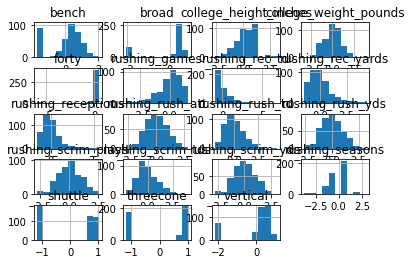

In [16]:
# histograms for some interesting measurements
X_train.hist()
pyplot.show()

In [17]:
result_df = test_df[['full_name', prediction_feature, 'position_group_rank']].copy()
print(result_df)
def result_df_viz(df, predictions, model_name):
    
    df[model_name] = predictions
    #return result_df.sort_values(by=['max_madden_pred'], ascending=False)
    return df

                  full_name  madden_cat  position_group_rank
fms_id                                                      
2337              Jay Ajayi          80                 13.0
3291          Malcolm Brown          70                 27.0
170          Ameer Abdullah          80                  4.0
2727          Josh Robinson          60                 17.0
4824          Trey Williams          60                 31.0
1685           Duke Johnson          80                  6.0
355            B.J. Catalon          40                 22.0
4539            T.J. Yeldon          80                  3.0
1327             David Cobb          70                 12.0
4695            Todd Gurley          80                  1.0
3485             Matt Jones          70                  7.0
2408        Jeremy Langford          70                  8.0
2123         Jahwan Edwards          60                 26.0
2854        Karlos Williams          60                 14.0
1606        Dominique Br

In [18]:
# Plot feature importance
def plot_feat_import(coef, model_title):
    feature_coef = pd.Series(index=X_train.columns, data=coef)
    print('{} model picked {} out of {} features'.format(model_title, str(sum(feature_coef != 0)), str(X_train.shape[1])))
    top_bottom_10 = pd.concat([feature_coef.sort_values().head(10), feature_coef.sort_values().tail(10)])
    top_bottom_10.plot(kind='barh', title='Feature importance (Top and bottom 10) - {} model'.format(model_title))
    #from W207 project (Fleishman, Hilton, Niu)
    
# Plot predictions
def plot_it(y_train, y_valid, model_title):
    plt.scatter(y_train, train_labels, c = "blue", alpha=0.6, marker = "o", label = "Training data")
    plt.scatter(y_valid, dev_labels, c = "green", alpha=0.6, marker = "o", label = "Validation data")
    plt.title(model_title)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()
    
class_names = [40, 50, 60, 70, 80, 90]

In [19]:
#Logistic Regression:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
madden_predict = clf.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print(madden_predict)
result_df_viz(result_df, madden_predict, 'Log_Regression')


Accuracy:  0.46153846153846156
R2 : -1.391509433962264
[70 40 70 60 60 80 40 70 40 80 40 40 40 60 40 40 80 40 40 60 70 70 80 70
 60 40]


,full_name,madden_cat,position_group_rank,Log_Regression
fms_id,,,,
2337,Jay Ajayi,80,13.0,70
3291,Malcolm Brown,70,27.0,40
170,Ameer Abdullah,80,4.0,70
2727,Josh Robinson,60,17.0,60
4824,Trey Williams,60,31.0,60
1685,Duke Johnson,80,6.0,80
355,B.J. Catalon,40,22.0,40
4539,T.J. Yeldon,80,3.0,70
1327,David Cobb,70,12.0,40


Lasso Model
Accuracy:  0.038461538461538464
R2 : 0.1430424528301888
MSE : 107.5
Lasso model picked 13 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso
fms_id,,,,,
2337,Jay Ajayi,80,13.0,70,71.0
3291,Malcolm Brown,70,27.0,40,56.0
170,Ameer Abdullah,80,4.0,70,67.0
2727,Josh Robinson,60,17.0,60,66.0
4824,Trey Williams,60,31.0,60,58.0
1685,Duke Johnson,80,6.0,80,72.0
355,B.J. Catalon,40,22.0,40,51.0
4539,T.J. Yeldon,80,3.0,70,69.0
1327,David Cobb,70,12.0,40,60.0


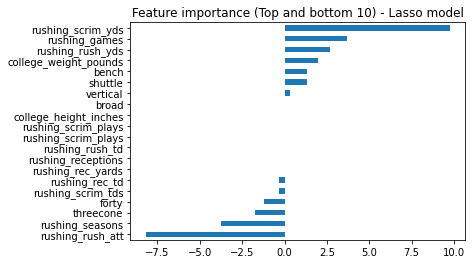

In [20]:
#Lasso:
alpha = 0.1
lasso_model = Lasso(alpha=alpha).fit(X_train, Y_train)
madden_predict = lasso_model.predict(X_validation)

madden_predict = np.around(madden_predict, decimals = 0)

print('Lasso Model')
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))

plot_feat_import(lasso_model.coef_, 'Lasso')  
#plot_it()
print('----------')
result_df_viz(result_df, madden_predict, 'Lasso')


Accuracy:  0.07692307692307693
R2 : 0.16511792452830198
MSE : 104.73076923076923
LassoCV Model
Lassocv model picked 12 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV
fms_id,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0
3291,Malcolm Brown,70,27.0,40,56.0,56.0
170,Ameer Abdullah,80,4.0,70,67.0,67.0
2727,Josh Robinson,60,17.0,60,66.0,64.0
4824,Trey Williams,60,31.0,60,58.0,57.0
1685,Duke Johnson,80,6.0,80,72.0,71.0
355,B.J. Catalon,40,22.0,40,51.0,52.0
4539,T.J. Yeldon,80,3.0,70,69.0,69.0
1327,David Cobb,70,12.0,40,60.0,61.0


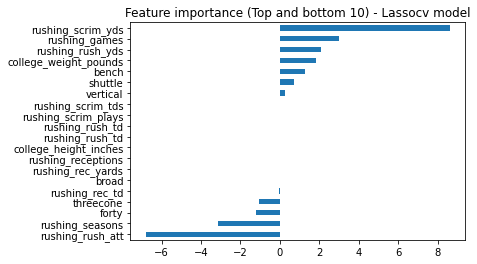

In [21]:
#Lassocv:

lasso_modelcv = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
madden_predict = lasso_modelcv.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
print('LassoCV Model')
plot_feat_import(lasso_modelcv.coef_, 'Lassocv') 
print('----------')
result_df_viz(result_df, madden_predict, 'LassoCV')


RidgeCV Model
Accuracy:  0.07692307692307693
R2 : 0.15775943396226422
MSE : 105.65384615384616
RidgeCV model picked 19 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV
fms_id,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0
1327,David Cobb,70,12.0,40,60.0,61.0,61.0


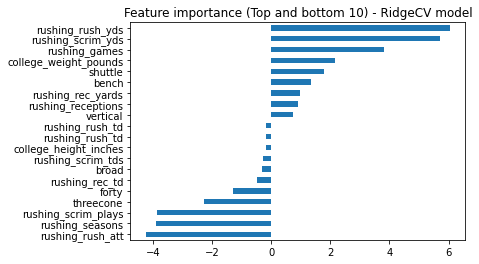

In [22]:
#RidgeCV:

ridge_model = RidgeCV(cv=5).fit(X_train, Y_train)
madden_predict = ridge_model.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)

print('RidgeCV Model')
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))

plot_feat_import(ridge_model.coef_, 'RidgeCV')
print('----------')
result_df_viz(result_df, madden_predict, 'RidgeCV')

ElasticNetCV Model
Accuracy:  0.07692307692307693
R2 : 0.14733490566037744
MSE : 106.96153846153847
ElasticNetCV model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV
fms_id,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0


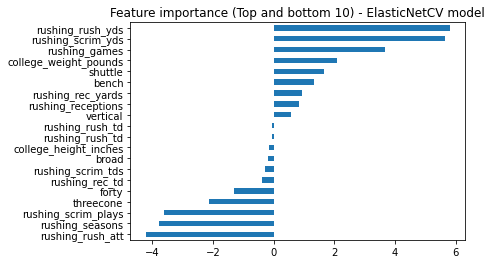

In [23]:
#ElasticNetCV:

elasticnetcv_model = ElasticNetCV(cv=5, random_state=0).fit(X_train, Y_train)
madden_predict = elasticnetcv_model.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print('ElasticNetCV Model')
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(elasticnetcv_model.coef_, 'ElasticNetCV')
result_df_viz(result_df, madden_predict, 'ElasticNetCV')

Accuracy:  0.3076923076923077
R2 : -2.158018867924528
MSE : 396.15384615384613
Decision Tree Regressor model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg
fms_id,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0


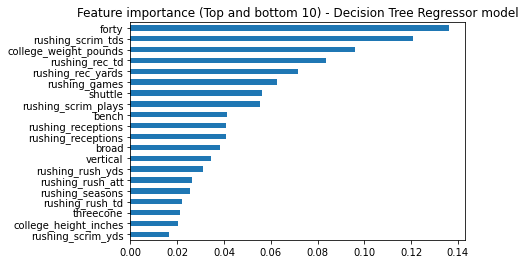

In [24]:
#Decision Tree Regressor
from sklearn import tree
decisiontreeregrssor = DecisionTreeRegressor()
decisiontreeregrssor.fit(X_train, Y_train)
madden_predict = decisiontreeregrssor.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(decisiontreeregrssor.feature_importances_, 'Decision Tree Regressor')
result_df_viz(result_df, madden_predict, 'Decision_Tree_Reg')

Accuracy:  0.46153846153846156
R2 : -0.07311320754716966
MSE : 134.6153846153846
AdaBoostRegressor model picked 19 out of 19 features
[[1 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 6 2 0 0]
 [0 0 5 3 0 0]
 [1 0 1 4 2 0]
 [0 0 0 0 0 0]]


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost
fms_id,,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0,70.0
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0,70.0
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0,70.0
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0,60.0
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0,70.0
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0,80.0
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0,60.0
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0,60.0
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0,60.0


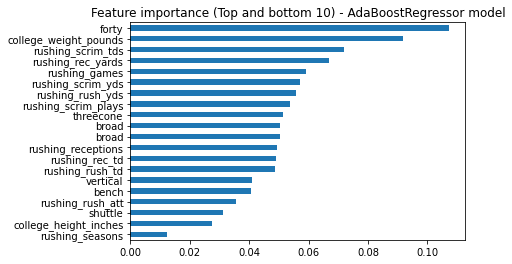

In [25]:
#Adaboost
adaboostregressor = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse'), n_estimators=100, loss='linear', learning_rate=1, random_state=1)
adaboostregressor.fit(X_train, Y_train)
madden_predict = adaboostregressor.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(adaboostregressor.feature_importances_, 'AdaBoostRegressor')
adaboost_mat = confusion_matrix(Y_validation, madden_predict, labels = class_names)
print(adaboost_mat)
result_df_viz(result_df, madden_predict, 'AdaBoost')
#plot_confusion_matrix(adaboostregressor, X_validation, Y_validation)


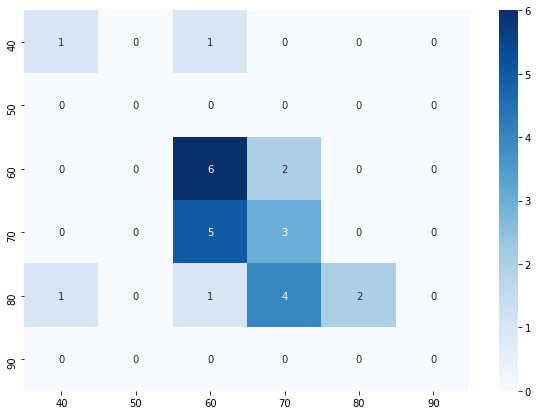

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = adaboost_mat
df_cm = pd.DataFrame(array, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

Accuracy:  0.07692307692307693
R2 : -1.9433962264150941
MSE : 369.2307692307692
Decision Tree Classifier model picked 19 out of 19 features
[[1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [5 0 0 2 1 0]
 [2 0 4 1 1 0]
 [2 1 0 3 0 2]
 [0 0 0 0 0 0]]


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class
fms_id,,,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0,70.0,70
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0,70.0,60
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0,70.0,70
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0,60.0,80
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0,70.0,70
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0,80.0,40
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0,60.0,50
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0,60.0,40
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0,60.0,60


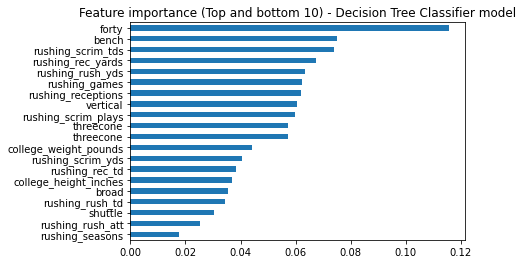

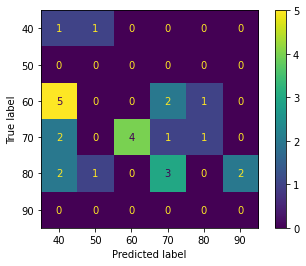

In [27]:
#Decision Tree
from sklearn import tree
decisiontree = DecisionTreeClassifier(max_depth = 100)
decisiontree.fit(X_train, Y_train)
madden_predict = decisiontree.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(decisiontree.feature_importances_, 'Decision Tree Classifier')
print(confusion_matrix(Y_validation, madden_predict))
plot_confusion_matrix(decisiontree, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'Decision_Tree_Class')

Accuracy:  0.2692307692307692
R2 : -2.0353773584905657
MSE : 380.7692307692308
Extra Tree Classifier model picked 19 out of 19 features
[[2 0 0 0]
 [6 1 1 0]
 [4 1 2 1]
 [2 0 4 2]]


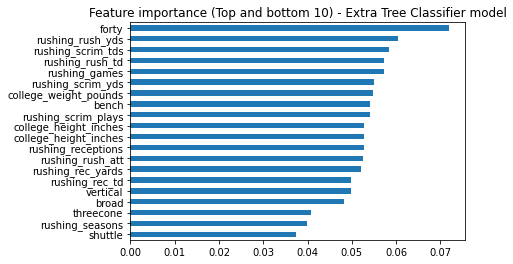

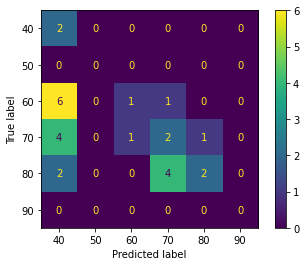

In [28]:
#Extra Tree


from sklearn import tree
extradecisiontree = ExtraTreesClassifier(max_depth = 300)
extradecisiontree.fit(X_train, Y_train)
madden_predict = extradecisiontree.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(extradecisiontree.feature_importances_, 'Extra Tree Classifier')
result_df_viz(result_df, madden_predict, 'Extra_Tree')
print(confusion_matrix(Y_validation, madden_predict))
plot_confusion_matrix(extradecisiontree, X_validation, Y_validation, labels=class_names)

Accuracy:  0.07692307692307693
R2 : -3.8443396226415087
MSE : 607.6923076923077
AdaBoostClassifier model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class
fms_id,,,,,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0,70.0,70,70,70
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0,70.0,60,40,60
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0,70.0,70,70,80
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0,60.0,80,60,90
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0,70.0,70,40,70
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0,80.0,40,80,40
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0,60.0,50,40,80
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0,60.0,40,70,40
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0,60.0,60,70,60


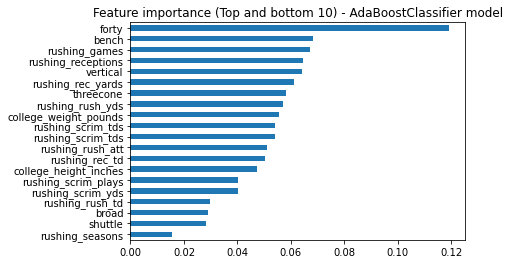

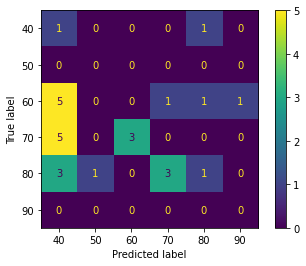

In [29]:
#Adaboost
adaboostclassifier = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500)
adaboostclassifier.fit(X_train, Y_train)
madden_predict = adaboostclassifier.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(adaboostclassifier.feature_importances_, 'AdaBoostClassifier')

plot_confusion_matrix(adaboostclassifier, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'AdaBoost_Class')


Accuracy:  0.34615384615384615
R2 : -1.7900943396226414
MSE : 350.0


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM
fms_id,,,,,,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0,70.0,70,70,70,70
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0,70.0,60,40,60,70
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0,70.0,70,70,80,70
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0,60.0,80,60,90,60
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0,70.0,70,40,70,60
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0,80.0,40,80,40,70
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0,60.0,50,40,80,40
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0,60.0,40,70,40,70
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0,60.0,60,70,60,40


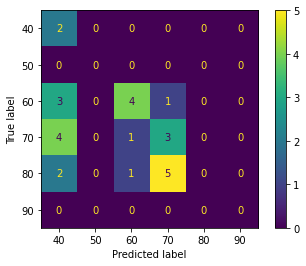

In [30]:
#SVM
svmclassifier = SVC(gamma='auto')
svmclassifier.fit(X_train, Y_train)
madden_predict = svmclassifier.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
#plot_feat_import(svmclassifier.feature_importances_, 'SVC')
plot_confusion_matrix(svmclassifier, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'SVM')

Accuracy:  0.34615384615384615
R2 : -1.3301886792452828
MSE : 292.3076923076923
Random Forest model picked 19 out of 19 features


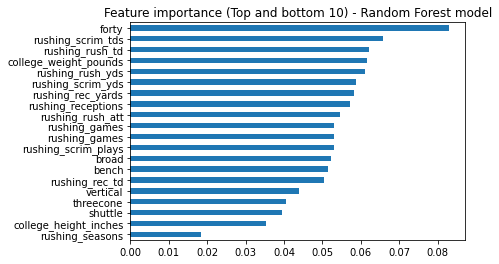

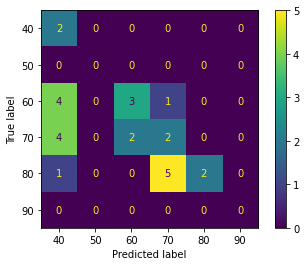

In [31]:
#RandomForest
rfclassifier = RandomForestClassifier()
rfclassifier.fit(X_train, Y_train)
madden_predict = rfclassifier.predict(X_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(rfclassifier.feature_importances_, 'Random Forest')
result_df_viz(result_df, madden_predict, 'RF_Class')
plot_confusion_matrix(rfclassifier, X_validation, Y_validation, labels = class_names)

In [32]:
#PCA with Linear Regression
pca = PCA(n_components=5)
pca_x = pca.fit_transform(X_train)
pca_validation = pca.transform(X_validation)

log_pca = LogisticRegression(random_state=0).fit(pca_x, Y_train)
madden_predict = log_pca.predict(pca_validation)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
#print(log_pca.coef_.shape)
#plot_feat_import(log_pca.coef_, 'PCA with Log Regression')
result_df_viz(result_df, madden_predict, 'Log_PCA')

Accuracy:  0.3076923076923077
R2 : -1.9740566037735845
MSE : 373.0769230769231


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA
fms_id,,,,,,,,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0,70.0,70,70,70,70,70,70
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0,70.0,60,40,60,70,40,40
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0,70.0,70,70,80,70,70,70
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0,60.0,80,60,90,60,60,40
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0,70.0,70,40,70,60,70,60
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0,80.0,40,80,40,70,70,70
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0,60.0,50,40,80,40,40,40
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0,60.0,40,70,40,70,70,70
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0,60.0,60,70,60,40,40,40


Accuracy:  0.0
R2 : -0.18349056603773573
MSE : 148.46153846153845
Gradient Booster Regressor model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA,GB_Regressor
fms_id,,,,,,,,,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0,70.0,70,70,70,70,70,70,72.0
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0,70.0,60,40,60,70,40,40,58.0
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0,70.0,70,70,80,70,70,70,63.0
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0,60.0,80,60,90,60,60,40,56.0
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0,70.0,70,40,70,60,70,60,59.0
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0,80.0,40,80,40,70,70,70,79.0
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0,60.0,50,40,80,40,40,40,48.0
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0,60.0,40,70,40,70,70,70,56.0
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0,60.0,60,70,60,40,40,40,54.0


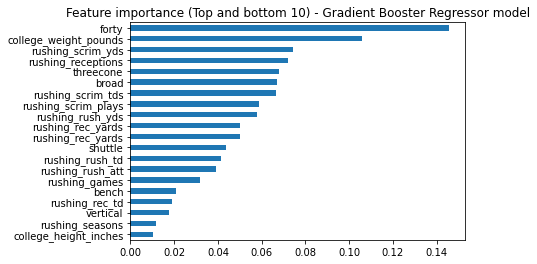

In [33]:
#Gradient Booster Regressor
import numpy as np
gradientboostingregressor = GradientBoostingRegressor(random_state=0)
gradientboostingregressor.fit(X_train, Y_train)
madden_predict = gradientboostingregressor.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print('Accuracy:  ' + str(accuracy_score(Y_validation, madden_predict)))
print('R2 : ' + str(r2_score(Y_validation, madden_predict)))
print('MSE : ' + str(mean_squared_error(Y_validation, madden_predict)))
plot_feat_import(gradientboostingregressor.feature_importances_, 'Gradient Booster Regressor')
result_df_viz(result_df, madden_predict, 'GB_Regressor')

In [34]:
from scipy.stats import rankdata
print(result_df.columns[3:])
rank_df = result_df[result_df.columns[3:]]
#for col in rank_df.columns:
#    rank_df[col] = rankdata(rank_df[col].values)

Index(['Log_Regression', 'Lasso', 'LassoCV', 'RidgeCV', 'ElasticNetCV',
       'Decision_Tree_Reg', 'AdaBoost', 'Decision_Tree_Class', 'Extra_Tree',
       'AdaBoost_Class', 'SVM', 'RF_Class', 'Log_PCA', 'GB_Regressor'],
      dtype='object')


In [35]:
def rank(row):
    print()
    return row.sum()/len(row)
result_df['rank'] = rank_df.apply(rank, axis=1)
result_df

,full_name,madden_cat,position_group_rank,Log_Regression,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,AdaBoost,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA,GB_Regressor,rank
fms_id,,,,,,,,,,,,,,,,,,
2337,Jay Ajayi,80,13.0,70,71.0,71.0,70.0,70.0,70.0,70.0,70,70,70,70,70,70,72.0,70.285714
3291,Malcolm Brown,70,27.0,40,56.0,56.0,56.0,56.0,40.0,70.0,60,40,60,70,40,40,58.0,53.000000
170,Ameer Abdullah,80,4.0,70,67.0,67.0,67.0,67.0,40.0,70.0,70,70,80,70,70,70,63.0,67.214286
2727,Josh Robinson,60,17.0,60,66.0,64.0,66.0,66.0,50.0,60.0,80,60,90,60,60,40,56.0,62.714286
4824,Trey Williams,60,31.0,60,58.0,57.0,58.0,58.0,40.0,70.0,70,40,70,60,70,60,59.0,59.285714
1685,Duke Johnson,80,6.0,80,72.0,71.0,72.0,72.0,80.0,80.0,40,80,40,70,70,70,79.0,69.714286
355,B.J. Catalon,40,22.0,40,51.0,52.0,52.0,52.0,40.0,60.0,50,40,80,40,40,40,48.0,48.928571
4539,T.J. Yeldon,80,3.0,70,69.0,69.0,69.0,69.0,80.0,60.0,40,70,40,70,70,70,56.0,64.428571
1327,David Cobb,70,12.0,40,60.0,61.0,61.0,61.0,70.0,60.0,60,70,60,40,40,40,54.0,55.500000


In [40]:
#def rank(row):
#    print()
#    return row.sum()/len(row)
#result_df['rank'] = rankdata(rank_df.apply(rank, axis=1))

ordered_df = result_df[['full_name', 'AdaBoost', prediction_feature, 'position_group_rank']].sort_values(by=['AdaBoost'], ascending=False)
ordered_df

,full_name,AdaBoost,madden_cat,position_group_rank
fms_id,,,,
1685,Duke Johnson,80.0,80,6.0
4695,Todd Gurley,80.0,80,1.0
2337,Jay Ajayi,70.0,80,13.0
170,Ameer Abdullah,70.0,80,4.0
4824,Trey Williams,70.0,60,31.0
2333,Javorius Allen,70.0,70,10.0
4642,Tevin Coleman,70.0,80,5.0
3542,Melvin Gordon,70.0,80,2.0
3563,Michael Dyer,70.0,60,28.0


In [41]:
ordered_df.to_csv('rank_of_picks.csv')

eclf = VotingClassifier(estimators=[('svc', svmclassifier), ('extratrees', extradecisiontree), ('rf', rfclassifier), ('logpca', log_pca)],voting='hard')


for clf, label in zip([svmclassifier, extradecisiontree, rfclassifier, log_pca, eclf], ['SVC', 'Extra Trees', 'Random Forest', 'Log_pca', 'Ensemble']): 
    scores = cross_val_score(clf, value_data, label_data, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
#



In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
#models.append(('LASSO', Lasso(alpha=0.1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier(n_estimators=200)))
models.append(('RFC', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('ETC', ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, value_data, label_data, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


In [ ]:
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()